In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import json
from copy import deepcopy, copy
import os
import sys
from matplotlib import cm
import seaborn as sns
import pandas as pd
from matplotlib.colors import to_rgba
from collections import Counter
from tqdm import tqdm
import matplotlib.ticker as ticker

%matplotlib inline
plt.style.use('seaborn')
sns.set(font_scale=1.3)

/tmp/ipykernel_1077669/2153332482.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def get_ref_point_minmax(min_obj, max_obj, n_objectives, beta=0.1):
    #getting reference point, see Section 6.2
    ref_point = []
    for k in range(n_objectives):
        b = min_obj[k] - beta * (max_obj[k]-min_obj[k])
        ref_point.append(b)
    ref_point = np.array(ref_point)
    return ref_point

In [3]:
from pygmo import hypervolume

def calculateHypervolume(fitness_pairs, ref_point, n_objectives=2):
    #Hypervolume metric calculation
    ref_point_ = 1.0-np.array(ref_point)
    A = 1.0-np.array(fitness_pairs)
    hv = hypervolume(A)
    try:
        HV = hv.compute(ref_point_)
    except Exception as e: #problem with the reference point
        A = np.minimum(A, ref_point_)-1e-6
        hv = hypervolume(A)
        HV = hv.compute(ref_point_)
    return HV

from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm
import math
def angle(u,v):
    dot_product = (u*v).sum(axis=1)
    c = dot_product/(norm(u,axis=1)*norm(v,axis=1)) 
    angle_value = arccos(clip(c, -1, 1))
    angle_value = (angle_value/math.pi)*180
    return angle_value

def calculateSpaceCoverage(fitness_pairs, ref_point=[], n_objectives=2):
    #Coverage metric calculation
    M = 361
    F = np.array(fitness_pairs).reshape(-1, n_objectives)
    ref_point = np.array(ref_point)
    F -= ref_point
    axis = np.array([0,1]).reshape(1,2)
    angles = angle(F,axis)
    hist,_ = np.histogram(angles, bins = np.linspace(0,90,M))
    cnt = np.where(hist> 0)[0].shape[0]
    return cnt/float(M)

In [4]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
def build_front(objectives, test_objectives, hyperparameters, model_ids, epochs, n_objectives, plot=False, ax=None, show_test=False, color=None, marker='.'):
    sorting = NonDominatedSorting()
    solutions = -np.array(objectives).reshape(-1,n_objectives)
    _, ind = np.unique(solutions, return_index=True, axis=0)
    solutions = solutions[ind]
    objectives = [objectives[i] for i in ind]    
    test_objectives = [test_objectives[i] for i in ind]
    hyperparameters = [hyperparameters[i] for i in ind]
    model_ids = [model_ids[i] for i in ind]
    epochs = [epochs[i] for i in ind]
    
    fronts = sorting.do(solutions, return_rank=False)
    
    #obtain non-dominated front
    first_front = np.array([objectives[i] for i in fronts[0]])
    first_front_test = np.array([test_objectives[i] for i in fronts[0]])
    first_front_hyperparameters = np.array([hyperparameters[i] for i in fronts[0]])
    first_front_model_ids = np.array([model_ids[i] for i in fronts[0]])
    first_front_epochs = np.array([epochs[i] for i in fronts[0]])
    
    line=None
    if plot:
        f1 = np.array(first_front[:,0])
        f2 = np.array(first_front[:,1])
        ind = np.argsort(f1)
        f1 = f1[ind]
        f2 = f2[ind]
    
        line,=ax.plot(f1,f2, color=color, marker=marker, linestyle='None', linewidth=1, markersize=5)
    return first_front, first_front_test, first_front_hyperparameters, first_front_model_ids, first_front_epochs, line

In [5]:
import pickle
import json
from datetime import datetime

def collect_solutions(folder, n_objectives, time_step=60):
    if not os.path.exists(folder):
        return [], [], [],[], [], []

    if 'Ray' in folder or 'ASHA' in folder:
        results_folder = 'results'
    elif 'BoTorch' in folder or 'NSGAII' in folder:
        results_folder = 'all_results'
    files = list(os.listdir(os.path.join(folder, results_folder)))
    if len(files) == 0:
        return [], [], [],[], [], []
    all_data = []
    for file in files:
        try:
            data = json.load(open(os.path.join(folder, results_folder, file),'r'))
        except Exception as e:
            print(folder, file)
            
        for epoch in data:
            data[epoch]['time'] = datetime.strptime(data[epoch]['time'], "%d/%m/%Y, %H:%M:%S")
            data[epoch]['time'] = int((data[epoch]['time']-datetime(1970,1,1)).total_seconds())
        
            all_data.append(data[epoch])
        
    all_data = sorted(all_data, key = lambda x: x['time'])
    
    all_scores = [x['val_score'] for x in all_data]
    all_scores_test = [x['test_score'] for x in all_data]
    all_hyperparameters = [x['config'] for x in all_data]
    total_time = (all_data[-1]['time']-all_data[0]['time'])//time_step + 100
    
    all_scores_divided = [[] for i in range(total_time)]
    all_scores_test_divided = [[] for i in range(total_time)]
    all_hyperparameters_divided = [[] for i in range(total_time)]
    
    for i in range(len(all_data)):
        cur_time = (all_data[i]['time']-all_data[0]['time'])//time_step
        all_scores_divided[cur_time].append(all_data[i]['val_score'])
        all_scores_test_divided[cur_time].append(all_data[i]['test_score'])
        all_hyperparameters_divided[cur_time].append(all_data[i]['config'])
    
    while len(all_scores_divided[-1]) == 0:
        all_scores_divided.pop()
        all_scores_test_divided.pop()
        all_hyperparameters_divided.pop()
    
    return all_scores, all_scores_test, all_hyperparameters, all_scores_divided, all_scores_test_divided, all_hyperparameters_divided

In [6]:
import pickle
import json
from datetime import datetime

def check_files(folder, target_evals, n_objectives, time_step=60):
    if not os.path.exists(folder):
        print(folder, 'doesnt exist')
        return [], [], [],[], [], []

    if 'Ray' in folder or 'ASHA' in folder:
        results_folder = 'results'
    elif 'BoTorch' in folder or 'NSGAII' in folder:
        results_folder = 'all_results'
    files = list(os.listdir(os.path.join(folder, results_folder)))

    if len(files) == 0:
        print(folder, 'doesnt exist')
        return [], [], [],[], [], []
    all_data = []
    for file in files:
        try:
            data = json.load(open(os.path.join(folder, results_folder, file),'r'))
        except Exception as e:
            print(folder, file)

In [7]:
def read_and_plot_front(folder, n_objectives, ax=None, ref_point = None, time_step=60):
    if not os.path.exists(folder):
        return None, [], [], [], [], [], [], [], []
    
    if 'Ray' in folder or 'ASHA' in folder:
        results_folder = 'results'
    elif 'BoTorch' in folder or 'NSGAII' in folder:
        results_folder = 'all_results'

    files = list(os.listdir(os.path.join(folder, results_folder)))
    if len(files) == 0:
        return None, [], [], [], [], [], []
    all_data = []
    for file in files:
        try:
            data = json.load(open(os.path.join(folder, results_folder, file),'r'))
        except Exception as e:
            print(folder, file)
        for epoch in data:
            data[epoch]['epoch'] = epoch
            data[epoch]['model_id'] = int(file.split('.')[0])
            
            data[epoch]['time'] = datetime.strptime(data[epoch]['time'], "%d/%m/%Y, %H:%M:%S")
            data[epoch]['time'] = int((data[epoch]['time']-datetime(1970,1,1)).total_seconds())
            
            all_data.append(data[epoch])
            
    all_data = sorted(all_data, key = lambda x: x['time'])
        
    total_time = (all_data[-1]['time']-all_data[0]['time'])//time_step + 100
    
    all_scores = [[] for i in range(total_time)]
    all_scores_test = [[] for i in range(total_time)]
    all_hyperparameters = [[] for i in range(total_time)]
    all_model_ids = [[] for i in range(total_time)]
    all_epochs = [[] for i in range(total_time)]
    
    for i in range(len(all_data)):
        cur_time = (all_data[i]['time']-all_data[0]['time'])//time_step
        all_scores[cur_time].append(all_data[i]['val_score'])
        all_scores_test[cur_time].append(all_data[i]['test_score'])
        all_hyperparameters[cur_time].append(tuple(all_data[i]['config'].values()))
        all_model_ids[cur_time].append(all_data[i]['model_id'])
        all_epochs[cur_time].append(int(all_data[i]['epoch']))
    
    while len(all_scores[-1]) == 0:
        all_scores.pop()
        all_scores_test.pop()
        all_hyperparameters.pop()
        all_model_ids.pop()
        all_epochs.pop()
        
    hypervolumes = []
    hypervolumes_test = []
    coverages = []
    coverages_test = []
    
    archive_solutions = []
    front = set([])
    color,name = get_color_name(folder)
    for k in range(len(all_scores)):
        cur_f = list(front)
        cur_s = [x[0] for x in cur_f]
        cur_s_test = [x[1] for x in cur_f]
        cur_hps = [x[2] for x in cur_f]
        cur_model_ids = [x[3] for x in cur_f]
        cur_epochs = [x[4] for x in cur_f]
        
        solutions, solutions_test, front_hyperparameters, front_model_ids, front_epochs, line = build_front(cur_s+all_scores[k], cur_s_test+all_scores_test[k], cur_hps+all_hyperparameters[k], cur_model_ids+all_model_ids[k], cur_epochs+all_epochs[k], plot=False, n_objectives=n_objectives,color=color)
        for x,y,z,v,w in zip(solutions, solutions_test,front_hyperparameters,front_model_ids,front_epochs):
            front.add(tuple([tuple(x), tuple(y), tuple(z), v, w]))          
        solutions = [list(x) for x in solutions]
        solutions_test = [list(x) for x in solutions_test]
        
        hypervolume = calculateHypervolume(solutions, ref_point, n_objectives)
        if n_objectives == 2:
            coverage = calculateSpaceCoverage(solutions, ref_point, n_objectives)
        else:
            coverage = -1
            
        hypervolumes.append(hypervolume)
        coverages.append(coverage)
        
        hypervolume_test = calculateHypervolume(solutions_test, ref_point, n_objectives)
        if n_objectives == 2:
            coverage_test = calculateSpaceCoverage(solutions_test, ref_point, n_objectives)
        else:
            coverage_test = -1
            
        hypervolumes_test.append(hypervolume_test)
        coverages_test.append(coverage_test)

    final_hv = hypervolumes[-1]#calculateHypervolume(raw_scores, ref_point, n_objectives)
    
    return None, solutions, solutions_test, front_hyperparameters, front_model_ids, front_epochs, hypervolumes, hypervolumes_test, final_hv, coverages, coverages_test
    

In [8]:
from matplotlib.pyplot import figure
def plot_multiple(n_objectives, seeds = 42, epoch = 100, folders = [], given_names = [], labels = [], max_time=60, title='',legend=True, plot_fronts=True, zoom_in = (), ref_point=None, pareto_front=None, plot_name = '', colors=None, time_step=60, text=''):
    ax = None
    if plot_fronts:        
        fig, ax = plt.subplots(figsize=(4.5,4.5))    
    
    all_fronts = []
    all_solutions_by_algorithm = []
    
    if plot_fronts:
        for folder in folders:
            cur_algorithm_solutions = []                    
            for seed in seeds:
                if not os.path.exists(os.path.join(folder, str(seed), 'results')):
                    continue
                    
                solutions1, solutions_test, front_hyperparameters1, solutions1_divided, solutions_test_divided, front_hyperparameters1_divided = collect_solutions(os.path.join(folder, str(seed)),  
                time_step=time_step, n_objectives=n_objectives);    

                cur_front = []
                cur_size = 0
                for i in range(len(solutions1_divided)):
                    cur_size += len(solutions1_divided[i])
                    cur_front = build_front(solutions1_divided[i]+list(cur_front), solutions_test_divided[i]+list(cur_front), front_hyperparameters1_divided[i]+list(cur_front), front_hyperparameters1_divided[i]+list(cur_front), front_hyperparameters1_divided[i]+list(cur_front), plot=False, n_objectives=n_objectives)[0]    
                    all_fronts.append(list(cur_front))
                    
                cur_algorithm_solutions.append(solutions1)
            all_solutions_by_algorithm.append(cur_algorithm_solutions)
    print('ref:',ref_point)
    ideal_hv = calculateHypervolume(pareto_front, ref_point=ref_point, n_objectives=n_objectives)+1e-6
    print('ideal hv:',ideal_hv, 'calculated based on %d soluions' % len(pareto_front))
    
    lines = []
    
    all_hvs = []
    all_hvs_test = []    
    all_coverage = []
    all_coverage_test = []    
    
    selected_hvs = []
    selected_coverage = []
    cur_colors = []
    final_hpvs = []
    names = []
    all_algorithms_model_ids = []
    for alg_ind, folder in enumerate(folders):
        cur_hvs = []
        cur_hvs_test = []
        cur_final_hpvs = []
        all_epochs_model_ids = []
        cur_coverage = []
        cur_coverage_test = []
    
    
        for seed in seeds:
            if not os.path.exists(os.path.join(folder, str(seed), 'results')):
                    continue

            line, solutions, solutions_test, front_hyperparameters, front_model_ids, front_epochs, hvs, hvs_test, total_hpv, coverage, coverage_test =read_and_plot_front(os.path.join(folder, str(seed)), 
                                                                                              ax=ax,
                                                                                              ref_point=ref_point,
                                                                                              time_step=time_step, n_objectives=n_objectives,
                                                                                              );    
            cur_epochs_model_ids = []        
            for e, h, m, s in zip(front_epochs,front_hyperparameters, front_model_ids,solutions):
                cur_epochs_model_ids.append((e,h, m,s))
                
            if len(hvs):
                cur_hvs.append(np.array(hvs))
                cur_hvs_test.append(np.array(hvs_test))                
                
                cur_coverage.append(np.array(coverage))
                cur_coverage_test.append(np.array(coverage_test))                
                
            all_epochs_model_ids.append(cur_epochs_model_ids)
        
        shapes = [len(x) for x in cur_hvs]
        max_shape = np.max([len(x) for x in cur_hvs])
        min_shape = np.min([len(x) for x in cur_hvs])
        
        for i in range(len(cur_hvs)):
            cur_hvs[i] = list(cur_hvs[i])
            while len(cur_hvs[i]) < max_time:
                cur_hvs[i].append(cur_hvs[i][-1])
            cur_hvs[i] = np.array(cur_hvs[i])

            while len(cur_hvs[i]) > max_time:
                cur_hvs[i] = cur_hvs[i][:-1]

            cur_hvs_test[i] = list(cur_hvs_test[i])
            while len(cur_hvs_test[i]) < max_time:
                cur_hvs_test[i].append(cur_hvs_test[i][-1])
            cur_hvs_test[i] = np.array(cur_hvs_test[i])

            while len(cur_hvs_test[i]) > max_time:
                cur_hvs_test[i] = cur_hvs_test[i][:-1]

            if 'ASHA' in folder:
                cur_hvs[i] = cur_hvs[i][:max_time]
                cur_hvs_test[i] = cur_hvs_test[i][:max_time]           
        cur_hvs = np.array(cur_hvs)            
        cur_hvs_mean = np.mean(cur_hvs,axis=0)
        ###############################################
        
        for i in range(len(cur_coverage)):
            cur_coverage[i] = list(cur_coverage[i])
            while len(cur_coverage[i]) < max_time:
                cur_coverage[i].append(cur_coverage[i][-1])
            cur_coverage[i] = np.array(cur_coverage[i])

            while len(cur_coverage[i]) > max_time:
                cur_coverage[i] = cur_coverage[i][:-1]

            cur_coverage_test[i] = list(cur_coverage_test[i])
            while len(cur_coverage_test[i]) < max_time:
                cur_coverage_test[i].append(cur_coverage_test[i][-1])
            cur_coverage_test[i] = np.array(cur_coverage_test[i])

            while len(cur_coverage_test[i]) > max_time:
                cur_coverage_test[i] = cur_coverage_test[i][:-1]

            if 'ASHA' in folder:
                cur_coverage[i] = cur_coverage[i][:max_time]
                cur_coverage_test[i] = cur_coverage_test[i][:max_time]           
        cur_coverage = np.array(cur_coverage)            
        cur_coverage_mean = np.mean(cur_coverage,axis=0)
        
        final_hvs = cur_hvs[:,-1]
        final_coverage = cur_coverage[:,-1]
        
        if len(final_hvs)%2 == 0:
            index_run = len(final_hvs)//2-1
        else:
            index_run = len(final_hvs)//2
        
        median_run_index = np.argsort(final_hvs)[index_run]
        run_hv = final_hvs[median_run_index]
        run_coverage = final_coverage[median_run_index]
        selected_hvs.append(run_hv)
        selected_coverage.append(run_coverage)
        
        print('hypervolume: {} | median HV: {} | mean HV: {}'.format(final_hvs, np.median(final_hvs), np.mean(final_hvs)))
        print('coverage: {} | median coverage: {} | mean coverage: {}'.format(final_coverage, np.median(final_coverage), np.mean(final_coverage)))
        
        cur_hvs_max = np.max(cur_hvs,axis=0)
        cur_hvs_min = np.min(cur_hvs,axis=0)
        
        cur_hvs_test = np.array(cur_hvs_test)
        cur_hvs_test_mean = np.mean(cur_hvs_test,axis=0)
        cur_hvs_test_max = np.max(cur_hvs_test,axis=0)
        cur_hvs_test_min = np.min(cur_hvs_test,axis=0)
        
        all_hvs.append((cur_hvs_mean, cur_hvs_min, cur_hvs_max, cur_hvs))
        all_hvs_test.append((cur_hvs_test_mean, cur_hvs_test_min, cur_hvs_test_max, cur_hvs_test))
        
        ####################
        cur_coverage_max = np.max(cur_coverage,axis=0)
        cur_coverage_min = np.min(cur_coverage,axis=0)
        
        cur_coverage_test = np.array(cur_coverage_test)
        cur_coverage_test_mean = np.mean(cur_coverage_test,axis=0)
        cur_coverage_test_max = np.max(cur_coverage_test,axis=0)
        cur_coverage_test_min = np.min(cur_coverage_test,axis=0)
        
        all_coverage.append((cur_coverage_mean, cur_coverage_min, cur_coverage_max, cur_coverage))
        all_coverage_test.append((cur_coverage_test_mean, cur_coverage_test_min, cur_coverage_test_max, cur_coverage_test))
        
        
        lines.append(line)
        all_epochs_model_ids = all_epochs_model_ids[median_run_index]
        
        if plot_fronts:
            color,name = get_color_name(folder)
            if colors is not None:
                color = colors[alg_ind]
            marker = markers[name]
            names.append(name)
            alg_solutions = np.array(all_solutions_by_algorithm[alg_ind][median_run_index])
            build_front(alg_solutions, alg_solutions, alg_solutions, alg_solutions, alg_solutions,plot=plot_fronts, ax=ax, n_objectives=n_objectives, color=color, marker=marker)[0]
            cur_colors.append(color)
            
        all_algorithms_model_ids.append(all_epochs_model_ids)
    
    selected_hvs = np.array(selected_hvs)*100
    selected_coverage = np.array(selected_coverage)*100
    
    if plot_fronts:
        if legend:
            lgnd=plt.legend(labels = names,markerscale=2.0, ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True)
        
        ax.set_xlim(zoom_in[0][0], zoom_in[0][1])
        ax.set_ylim(zoom_in[1][0], zoom_in[1][1])
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])     
        plt.title(title)          
        
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x = text[0] * (xlim[1]-xlim[0]) + xlim[0]
        y = text[1] * (ylim[1]-ylim[0]) + ylim[0]
        gap = text[2] * (ylim[1]-ylim[0])
        
        rainbow_text(x=x, y=y, 
                     strings = ['Hypervolume:', '%4.1f'%selected_hvs[0], ', ', '%4.1f\n'%selected_hvs[1]] + ['Coverage:   ', '%4.1f'%selected_coverage[0], ', ', '%4.1f'%selected_coverage[1]], 
                     colors = ['black', cur_colors[0], 'black', cur_colors[1]] + ['black', cur_colors[0], 'black', cur_colors[1]], 
                     ax=ax, gap=gap, fontsize=text[3])
        
        format = plot_name[-4:]
        plt.savefig(plot_name.replace(format,'')+'_fronts'+format, bbox_inches='tight',dpi=300)
        plt.show()
    
    lines = []
    cnt = 0
    names = []
    figure(figsize = (4.5, 4.5), dpi = 100)

    for hv_mean, hv_min, hv_max, _ in all_hvs:
        err_up   = np.log10(np.abs(ideal_hv-np.array(hv_min))) - np.log10(np.abs(ideal_hv-hv_mean))
        err_low   = np.log10(np.abs(ideal_hv-np.array(hv_mean))) - np.log10(np.abs(ideal_hv-hv_max))
        folder = folders[cnt]
        color,name = get_color_name(folder)
        names.append(name)
        if colors is not None:
            color = colors[cnt]
        
        line, = plt.plot(np.arange(len(hv_mean)), np.log10(np.abs(ideal_hv-hv_mean)), color=color)
        plt.fill_between(np.arange(len(hv_mean)), np.log10(np.abs(ideal_hv-np.array(hv_min))), np.log10(np.abs(ideal_hv-np.array(hv_max))), color=color, alpha=0.1)
                  
        lines.append(line)
        cnt += 1
        
    
    if legend:
        if len(given_names) > 0:
            names = given_names
        plt.legend(handles = lines, labels = names, loc='upper right')
    plt.xlabel('Time (minutes)')    
    plt.ylabel(r'$Log_{10}$'+ ' Hypervolume difference')
    plt.title(title)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    plt.savefig(plot_name, bbox_inches='tight',dpi=300)
    plt.show()

    lines = []
    cnt = 0
    names = []
    figure(figsize = (4.5, 4.5), dpi = 100)

    for hv_test_mean, hv_test_min, hv_test_max, _ in all_hvs_test:
        folder = folders[cnt]
        color,name = get_color_name(folder)
        if colors is not None:
            color = colors[cnt]

        names.append(name)
        line, = plt.plot(np.arange(len(hv_test_mean)), np.log10(np.abs(ideal_hv-hv_test_mean)), color=color)
        plt.fill_between(np.arange(len(hv_test_mean)), np.log10(np.abs(ideal_hv-np.array(hv_test_min))), np.log10(np.abs(ideal_hv-np.array(hv_test_max))), color=color, alpha=0.1)

        lines.append(line)
        cnt += 1
    if legend:
        if len(given_names) > 0:
            names = given_names
        plt.legend(handles = lines, labels = names, loc='upper right')#, bbox_to_anchor=(1, 0.5))
    plt.xlabel('Time (minutes)')    
    plt.ylabel(r'$Log_{10}$'+ ' Hypervolume difference')
    plt.title(title + ', Test')
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    format = plot_name[-4:]
    plt.savefig(plot_name.replace(format,'')+'_test'+format, bbox_inches='tight',dpi=300)
    plt.show()

    return all_hvs, all_hvs_test, ideal_hv, all_coverage, all_coverage_test, names, all_algorithms_model_ids

In [9]:
def get_ref_point_and_pareto_front(n_objectives, seeds = 42, folders = [], time_step=60):
    all_fronts = []
    all_solutions_by_algorithm = []
    
    for folder in folders:
        cur_algorithm_solutions = []                    
        for seed in seeds:
            if 'pop32' in folder:
                target_evals=1600
            elif 'pop64' in folder:
                target_evals=3200
            
            check_files(os.path.join(folder, str(seed)), target_evals=target_evals, n_objectives=n_objectives)
            solutions1, solutions_test, front_hyperparameters1, solutions1_divided, solutions_test_divided, front_hyperparameters1_divided = collect_solutions(os.path.join(folder, str(seed)), time_step=time_step, n_objectives=n_objectives);    
            cur_front = []
            cur_size = 0
                
            for i in range(len(solutions1_divided)):
                cur_size += len(solutions1_divided[i])
                cur_front = build_front(solutions1_divided[i]+list(cur_front), solutions_test_divided[i]+list(cur_front), front_hyperparameters1_divided[i]+list(cur_front), front_hyperparameters1_divided[i]+list(cur_front), front_hyperparameters1_divided[i]+list(cur_front),plot=False, n_objectives=n_objectives)[0]    
                all_fronts.append(list(cur_front))
                            
    min_values = np.array([10**9 for i in range(n_objectives)])
    max_values = np.array([-10**9 for i in range(n_objectives)])
    pareto_front = []
    cnt = 0 
        
    for j,front in enumerate(tqdm(all_fronts)):
        front = np.array(front).reshape(-1,n_objectives)
        min_values = np.minimum(min_values, front.min(axis=0))
        max_values = np.maximum(max_values, front.max(axis=0))
        pareto_front = list(pareto_front)+list(front)
        if cnt % 100 == 0:
            pareto_front = build_front(list(pareto_front)+list(front), list(pareto_front)+list(front), list(pareto_front)+list(front), list(pareto_front)+list(front), list(pareto_front)+list(front), plot=False, ax=None, n_objectives=n_objectives)[0]
        cnt += 1
    
    pareto_front = build_front(list(pareto_front)+list(front), list(pareto_front)+list(front), list(pareto_front)+list(front), list(pareto_front)+list(front),  list(pareto_front)+list(front), plot=False, ax=None, n_objectives=n_objectives)[0]
        
    ref_point = get_ref_point_minmax(min_values, max_values, n_objectives=n_objectives)
    print(f'{ref_point=}')
    
    pareto_front = np.array(pareto_front).reshape(-1,n_objectives)
    return ref_point, pareto_front

In [10]:
ref_points, pareto_fronts = {}, {}
table_data = {}
table_data_test = {}
table_data_coverage = {}
table_data_coverage_test = {}
time_step = 60

We obtain the reference points using all runs of all algorithms (see paper) and the approximate pareto front

In [11]:
ref_points['precisionrecall_higgs'], pareto_fronts['precisionrecall_higgs'] = get_ref_point_and_pareto_front(folders = [
                  'results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_RayPBT_pop32_epsnet_precision_recall',                         
                  'results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_RayPBT_pop32_RandomSearch_precision_recall',                         
                  'results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_MOASHA_epsnet_precision_recall',                         
],
          seeds = range(42,52),
          n_objectives = 2
         );

/tmp/ipykernel_1077669/2567262022.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  first_front_hyperparameters = np.array([hyperparameters[i] for i in fronts[0]])
/tmp/ipykernel_1077669/2567262022.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  first_front_model_ids = np.array([model_ids[i] for i in fronts[0]])
/tmp/ipykernel_1077669/2567262022.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mean

results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_RayPBT_pop32_RandomSearch_precision_recall/42 doesnt exist
results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_RayPBT_pop32_RandomSearch_precision_recall/43 doesnt exist
results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_RayPBT_pop32_RandomSearch_precision_recall/44 doesnt exist
results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_RayPBT_pop32_RandomSearch_precision_recall/45 doesnt exist
results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_RayPBT_pop32_RandomSearch_precision_recall/46 doesnt exist
results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_RayPBT_pop32_RandomSearch_precision_recall/47 doesnt exist
results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_RayPBT_pop32_RandomSearch_precision_recall/48 doesnt exist
results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_RayPBT_pop32_RandomSearch_p

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 755/755 [00:00<00:00, 3136.81it/s]

ref_point=array([ 0.48141254, -0.09986734])


Can plot the approximate pareto front

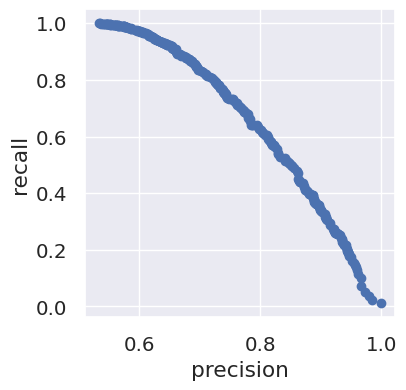

In [12]:
plt.figure(figsize=(4,4))
plt.xlabel('precision')
plt.ylabel('recall')
plt.scatter(pareto_fronts['precisionrecall_higgs'][:,0], pareto_fronts['precisionrecall_higgs'][:,1])

In [13]:
markers = {'MO-PBT':'v', 'MO-ASHA':'p', 'Random Search':'s'}

palette = sns.color_palette("colorblind",10)

colors = {'MO-PBT':palette[2],'random search': palette[7], 'objective 1': palette[0],'objective 2': palette[3],'random scalarization': palette[9],'max. scalarization':palette[5],
          'MO-ASHA':palette[4],'BO-MO-ASHA':palette[8], 'objective 3': palette[1]}

def get_color_name(folder):
    if 'RayPBT' in folder and 'epsnet' in folder:
        color = colors['MO-PBT']
        name = 'MO-PBT'
    elif 'MOASHA' in folder and 'epsnet' in folder:
        color = colors['MO-ASHA']
        name = 'MO-ASHA'
    elif 'RandomSearch' in folder:
        color = colors['random search']
        name = 'Random Search'

    return color, name

In [14]:
#visualziation tool from Matplotlib

import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D, offset_copy
from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox
import matplotlib.patches as patches
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch, Polygon

def add_fancy_patch_around(ax, bb, **kwargs):
    fancy = FancyBboxPatch(bb.p0, bb.width, bb.height,
                           fc=(1, 0.8, 1, 0.5), ec=(1, 0.5, 1, 0.5),
                           **kwargs)
    ax.add_patch(fancy)
    return fancy

def draw_bbox(ax, bb):
    # boxstyle=square with pad=0, i.e. bbox itself.
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="square,pad=0.",
                            ec="k", fc="none", zorder=10.,
                            )
    ax.add_patch(p_bbox)
    
def rainbow_text(x, y, strings, colors, orientation='horizontal',
                 ax=None, fontsize=10, gap=0.1, **kwargs):
    """
    Take a list of *strings* and *colors* and place them next to each
    other, with text strings[i] being shown in colors[i].

    Parameters
    ----------
    x, y : float
        Text position in data coordinates.
    strings : list of str
        The strings to draw.
    colors : list of color
        The colors to use.
    orientation : {'horizontal', 'vertical'}
    ax : Axes, optional
        The Axes to draw into. If None, the current axes will be used.
    **kwargs
        All other keyword arguments are passed to plt.text(), so you can
        set the font size, family, etc.
    """
    starting_x = x
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    fig = ax.figure
    canvas = fig.canvas

    assert orientation in ['horizontal', 'vertical']
    if orientation == 'vertical':
        kwargs.update(rotation=90, verticalalignment='bottom')
    
    offsets = []
    texts = []
    for s, c in zip(strings, colors):
        newline = False
        if s.endswith('\n'):
            newline = True
            s = s.replace('\n','')
        #props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        text = ax.text(starting_x, y, s, color=c, transform=t, fontsize=fontsize, family='Source Code Pro', **kwargs)
        texts.append(text)
        
        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        # Convert window extent from pixels to inches
        # to avoid issues displaying at different dpi
        ex = fig.dpi_scale_trans.inverted().transform_bbox(ex)
        #x=ex.width
        if newline:
            y -= gap
            x = 0.0
        else:
            x = ex.width
        #print(s,newline,x, starting_x)
        
        if not newline:
            t = text.get_transform() + \
                offset_copy(Affine2D(), fig=fig, x=x, y=0)
        else:
            t = ax.transData
            
        #offsets.append(x)
        #print(offsets)
    
    xmin = min([t.get_window_extent().xmin for t in texts])#+1
    xmax = max([t.get_window_extent().xmax for t in texts])#+1
    ymin = min([t.get_window_extent().ymin for t in texts])#+1
    ymax = max([t.get_window_extent().ymax for t in texts])#+1
    xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
    xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))
    
    pad = 0.013
    rect = FancyBboxPatch((xmin,ymin),
                             xmax-xmin, ymax-ymin,
                             boxstyle="round,pad=%f"%pad,
                             mutation_scale=1.0,
                             #fc=(1., 1, 1),
                             fc = (249/255.0,249/255.0,251/255.0,0.8),
                             ec=sns.color_palette("Paired")[1],
                             transform=fig.transFigure)
    
    ax.add_patch(rect)
    
    values = np.array([[xmin-pad, ymin + (ymax-ymin)/2.0],[xmax+pad,ymin + (ymax-ymin)/2.0]])
    
    rect = Polygon(values,
                 fc = (249/255.0,249/255.0,251/255.0,0.8),
                 ec=sns.color_palette("Paired")[1],
                 transform=fig.transFigure)

    ax.add_patch(rect)
    
    x_values = [xmin-0.,xmax]
    y_values = [ymin, ymax]

/tmp/ipykernel_1077669/2567262022.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  first_front_hyperparameters = np.array([hyperparameters[i] for i in fronts[0]])
/tmp/ipykernel_1077669/2567262022.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  first_front_model_ids = np.array([model_ids[i] for i in fronts[0]])
/tmp/ipykernel_1077669/2567262022.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mean

ref: [ 0.48141254 -0.09986734]
ideal hv: 0.3993260465163131 calculated based on 321 soluions
hypervolume: [0.39166558 0.39063476 0.39334962 0.3957324  0.39318368 0.38902305
 0.39179252 0.39428718 0.3934689  0.38846234] | median HV: 0.3924880994328017 | mean HV: 0.39216000343747787
coverage: [0.33795014 0.33518006 0.33240997 0.39889197 0.3767313  0.3434903
 0.35734072 0.37396122 0.36842105 0.34626039] | median coverage: 0.35180055401662047 | mean coverage: 0.35706371191135733
hypervolume: [0.3771216  0.37580794 0.36822545 0.37521513 0.37248191 0.37478758
 0.37817757 0.37965955 0.37201116 0.37241269] | median HV: 0.37500135743310026 | mean HV: 0.3745900576411704
coverage: [0.19944598 0.17451524 0.19390582 0.21052632 0.19390582 0.2132964
 0.21052632 0.24376731 0.18836565 0.1800554 ] | median coverage: 0.19667590027700832 | mean coverage: 0.2008310249307479


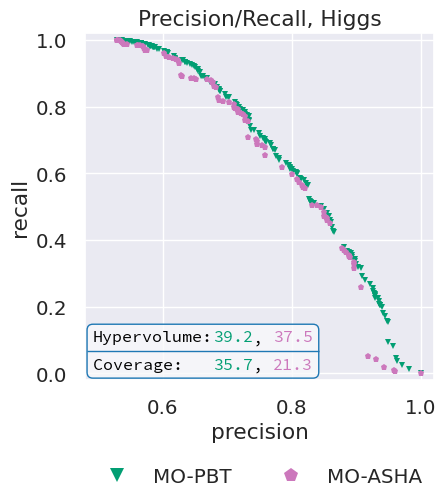

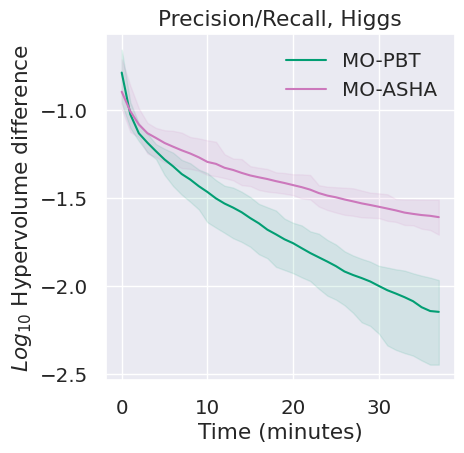

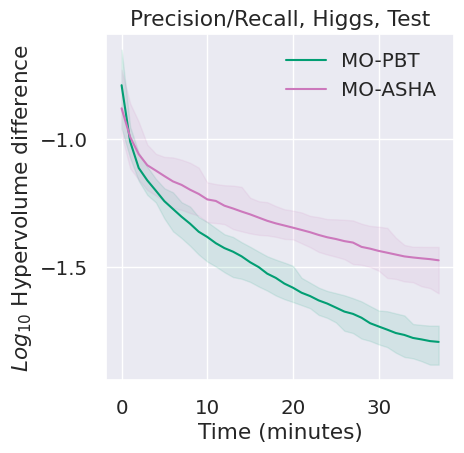

In [15]:
time_step = 60

all_hvs, all_hvs_test, ideal_hv, all_coverage, all_coverage_test, names,_ = plot_multiple(folders = [
                  'results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_RayPBT_pop32_epsnet_precision_recall',                         
                  'results_examples/Higgs/Higgs_tabular_classification_100_FTTransformer_MOASHA_epsnet_precision_recall',       
                      ],              
              seeds = range(42,52),
              zoom_in = ((0.48, 1.02), (-0.02, 1.02)),
              plot_name='images/precisionrecall_higgs.png',
              title = 'Precision/Recall, Higgs',
              max_time = 38,
              n_objectives = 2,
              labels = ['precision', 'recall'],
              ref_point = np.array([ 0.48141254, -0.09986734]), 
              pareto_front = pareto_fronts['precisionrecall_higgs'],
              plot_fronts=True,
              text = (0.022,0.112,0.08,12),
             );



We can save the hypervolume and coverage metric values, for validation and test subsets (along with std.)

In [16]:
table_data['precisionrecall_higgs'] = {}
for i,name in enumerate(names):   
    data = [x[-1] for x in all_hvs[i][3]]
    data = np.array(data)*100.0#)/ideal_hv
    table_data['precisionrecall_higgs'][name] = (np.mean(data), np.std(data))
table_data

table_data_test['precisionrecall_higgs'] = {}
for i,name in enumerate(names):   
    data = [x[-1] for x in all_hvs_test[i][3]]
    data = np.array(data)*100.0#)/ideal_hv
    table_data_test['precisionrecall_higgs'][name] = (np.mean(data), np.std(data))
table_data


{'precisionrecall_higgs': {'MO-PBT': (39.21600034374778, 0.21836261408202015),
  'MO-ASHA': (37.45900576411704, 0.3213032510680383)}}

In [17]:
table_data_coverage['precisionrecall_higgs'] = {}
for i,name in enumerate(names):   
    data = [x[-1] for x in all_coverage[i][3]]
    data = np.array(data)*100.0#)/ideal_hv
    table_data_coverage['precisionrecall_higgs'][name] = (np.mean(data), np.std(data))

table_data_coverage_test['precisionrecall_higgs'] = {}
for i,name in enumerate(names):   
    data = [x[-1] for x in all_coverage_test[i][3]]
    data = np.array(data)*100.0#)/ideal_hv
    table_data_coverage_test['precisionrecall_higgs'][name] = (np.mean(data), np.std(data))
table_data_coverage#_test


{'precisionrecall_higgs': {'MO-PBT': (35.706371191135744, 2.0746054674075096),
  'MO-ASHA': (20.083102493074794, 1.8879289984918264)}}